In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

class DynamicConv2D(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, K=4, strides=1, padding='valid'):
        super(DynamicConv2D, self).__init__()
        self.K = K  # number of candidate filters
        self.out_channels = out_channels
        self.convs = [layers.Conv2D(out_channels, kernel_size, strides=strides, padding=padding)
                      for _ in range(K)]
        self.fc = layers.Dense(K)  # controller to predict the attention weights

    def call(self, x):
        batch_size = tf.shape(x)[0]
        pooled = tf.reduce_mean(x, axis=[1, 2])  # global average pooling
        attention = self.fc(pooled)  # predict attention
        attention = tf.nn.softmax(attention, axis=1)  # softmax over K filters

        outputs = []
        for i in range(self.K):
            conv_out = self.convs[i](x)  # apply i-th convolution
            weight = tf.reshape(attention[:, i], (batch_size, 1, 1, 1))  # reshape for broadcasting
            outputs.append(conv_out * weight)

        output = tf.add_n(outputs)  # sum up weighted conv outputs
        return output


In [3]:
def build_dynamic_cnn(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # First DynamicConv2D layer
    x = DynamicConv2D(in_channels=3, out_channels=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Second DynamicConv2D layer
    x = DynamicConv2D(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Build and print the model
model = build_dynamic_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dynamic_conv2d (DynamicConv2D)  │ (None, 32, 32, 32)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dynamic_conv2d_1                │ (None, 16, 16, 64)     │        74,116 │
│ (DynamicConv2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,806 (2.30 MB)

 Trainable params: 603,614 (2.30 MB)

 Non-trainable params: 192 (768.00 B)

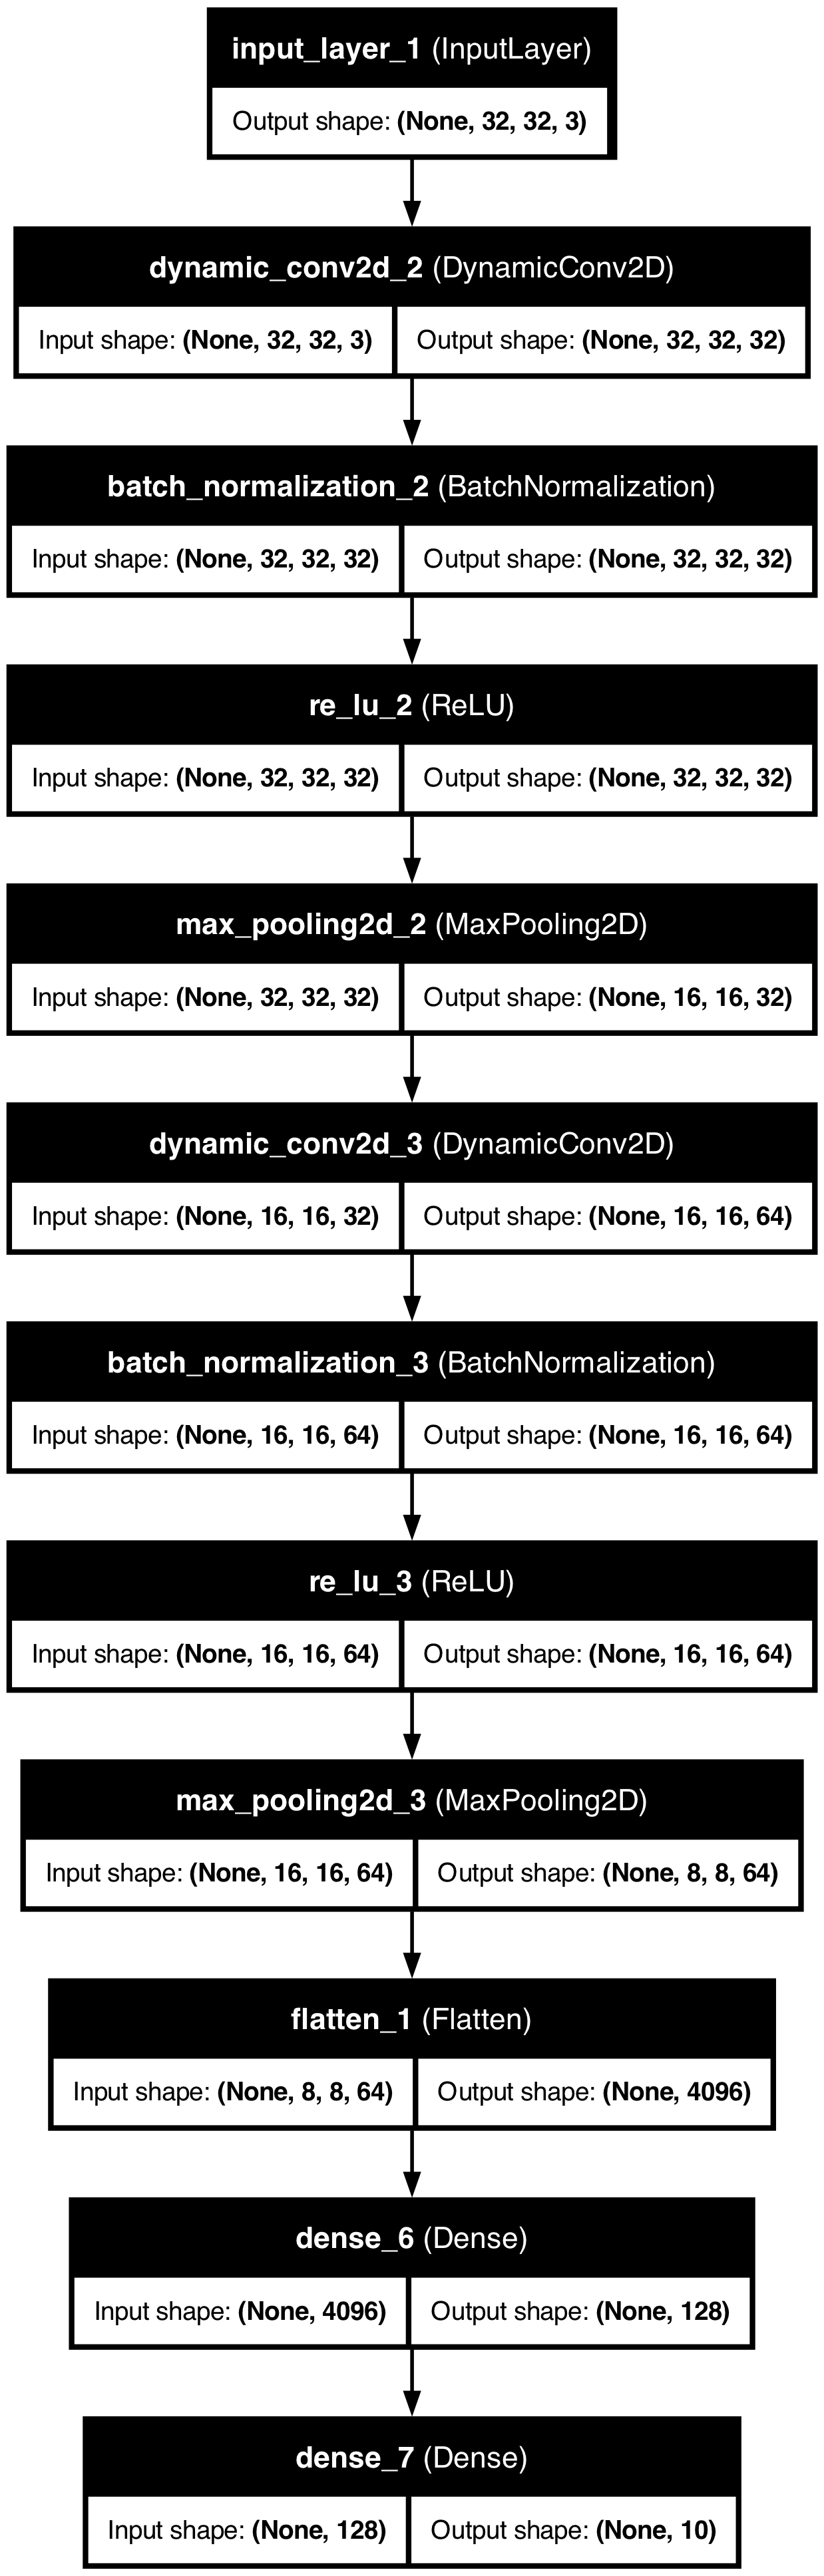

In [6]:
from IPython.display import Image
from tensorflow.keras.utils import plot_model

model = build_dynamic_cnn()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./dynamic_cnn_model.png')